# Found My Fitness Example

In [ ]:
#| default_exp fmf_biobert

Here we'll try using elements from the biobertApi module to label biomedical terms in the comments section of a Found My Fitness youtube video that looks like this :

>#### Import all functions from [PyPi](https://pypi.org/project/biobert-bern/0.0.1/) by typing into your terminal: 
pip install biobert-bern

><a href="http://www.youtube.com/watch?feature=player_embedded&v=g4QqJoox8tc
" target="_blank"><img src="http://img.youtube.com/vi/g4QqJoox8tc/0.jpg" 
alt="IMAGE Youtube Vid" width="240" height="180" border="10" /></a>
>>>![alt text](fmf_biobert_bern.png "Found My Fitness Youtube Video")

## Load Libraries and Data
> First we'll load all libraries we'll need and the YouTube comments for labeling

In [ ]:
from biobert_bern.biobertApi import *  #this grabs all functions from biobertApi .py file

Less than 5k characters. Only 1 block necessary.


In [ ]:
import requests
import re
import pandas as pd
from nbdev.showdoc import *
import fastai
from pathlib import *
import numpy as np     
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = Path('./text_sample') # save path
comment_csv= 'found_my_fitness_UCWF8SqJVNlx-ctXbLswcTcA_youtube_comments_only_121rows.csv'
coms = pd.read_csv(path/comment_csv) #load csv
coms.rename(columns = {'comment': 'comments'},inplace=True) # rename comment to comments

## Now start splitting off all the cumsums <5000 and stack them back together.
> The BERN api will only let us send text that is less thatn 5k characters at a time so we'll block the comments together in groups that are less than 5k each

### Create Section Labels

In [ ]:
coms = create_com_with_idx(coms); coms.tail(2)

,idx,vid_id,vid_channel_id,vid_deets,vid_response,title,publishedAt,tcomment_id,tcresponse,textDisplay,textOriginal,totalReplyCount,rep_comment,reply_id,comments,authorChannelId,com_id,comidx
119,119,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T11:20:13Z,NaN,"{'kind': 'youtube#comment', 'etag': 'yd5KSzb3_...",... and they said it gives you the munchies.,... and they said it gives you the munchies.,NaN,"{'kind': 'youtube#comment', 'etag': 'yd5KSzb3_...",Ugy2ZO2t370rDO-eWoZ4AaABAg.9husbe2WJcN9hvjM9rBbfr,... and they said it gives you the munchies.,UCiKwxLKyahZ2INq3VljI4DQ,Ugy2ZO2t370rDO-eWoZ4AaABAg.9husbe2WJcN9hvjM9rBbfr,119:: ... and they said it gives you the munch...
120,120,g4QqJoox8tc,NaN,NaN,NaN,NaN,2022-11-02T03:07:55Z,Ugx3lPLxH7NyOIZxzEl4AaABAg,"{'kind': 'youtube#commentThread', 'etag': 'Gzv...",My first thought was Rich Roll,My first thought was Rich Roll,0.0,NaN,NaN,My first thought was Rich Roll,UC_-vIy5tSDQWnAV0xM2B53w,Ugx3lPLxH7NyOIZxzEl4AaABAg,120:: my first thought was rich roll ::


## Create Text Blocks
> Here we'll put all the text together into blocks of 5,000 characters or less.  5k characters is the API limit on the BERN biobert labeler model.

In [ ]:
%%capture
blocks = create_all_text_blocks(df=coms)

### Check the top and bottom text blocks

In [ ]:
for o in blocks[:2]: print(o[:50]);print()
print('... ');print();
for o in blocks[-2:]: print(o[:50]); print()

0:: if exercise and/or the interaction with alcoho

23:: i wish i workout 6 days a week hard and when 

... 

81:: as a recovering alcoholic, damn sign me up fo

103:: i have to force myself, both to do exercise 



## Query BERN one block at a time

In [ ]:
dfo = pd.DataFrame()
for o in blocks:
    print(len(o))
    out = query_plain(text=o)
    dfo = dfo.append({'block':o, 'out':out},ignore_index=True)
dfo.tail(2)

4868
4080
4853
3668
4868
2046


,block,out
4,"81:: as a recovering alcoholic, damn sign me u...","{'annotations': [{'id': ['mesh:D000437', 'mim:..."
5,"103:: i have to force myself, both to do exerc...","{'annotations': [{'id': ['CHEBI:16236'], 'is_n..."


# Concat All Text Blocks into a nice labeled df

In [ ]:
def merge_annotations_with_textblock_idx(dfa,#daframe containing 'span' column with the text locations of each 
                                         dfi): #dataframe containing the comment index to reference later
    # create str_end col as type str
    dfa.span = dfa.span.astype(str)
    dfa ['str_end'] = dfa.span.str.replace(r".*'end': (\d+)}",r"\1",regex=True)
    dfa.str_end = dfa.str_end.astype(int)  # make str end as type str

    #add dfi_idx col
    dfi.reset_index(inplace=True)
    dfi.rename(columns={'index':'dfi_bloc_idx'},inplace=True)
    dfi.dfi_bloc_idx = dfi.dfi_bloc_idx.astype(int)
    # create com_idx pulling it from the text via regex
    dfi['comidx'] = dfi.text.replace(r"((\d+)?::.*)",r"\2",regex=True)
    dfi.comidx = dfi.comidx.astype(int)
    print(type(dfi.comidx[0]))
    dfi.comidx = dfi.comidx.astype(int)

    for o,m in zip(dfi.index,dfi.span):  #add dfi_idx col to dfa 
        x,y = m #open span tuple
        #write conditions for specific df rows
        conds = (dfa.str_end > x) & (dfa.str_end < y)
        dfa['dfi_bloc_idx'] = ''
        dfa.loc[conds,'dfi_bloc_idx'] = o #save the index of the dfi span that fits to dfa
        dfa.dfi_bloc_idx = dfa.dfi_bloc_idx.astype(str)
    # dfa.merge(dfi, left_on='dfi_idx',right_index=True)
    df = dfa.merge(dfi, left_on='dfi_bloc_idx',right_on='dfi_bloc_idx');
    
    return df

In [ ]:
def dfi_dfa_prep(dfa,dfi):
    '''Prepares dfi and dfa to both have dfi_bloc_idx'''
    dfi.reset_index(drop=True,inplace=True)
    dfi['dfi_bloc_idx'] = dfi.index
    # dfi.rename(columns={'index':'dfi_bloc_idx'},inplace=True)
    dfi.dfi_bloc_idx = dfi.dfi_bloc_idx.astype(int)
    # create com_idx pulling it from the text via regex
    dfi['comidx'] = dfi.text.replace(r"((\d+)?::.*)",r"\2",regex=True)
    dfi.comidx = dfi.comidx.astype(int)

    # create str_end col as type str
    dfa.span = dfa.span.astype(str)
    dfa ['str_end'] = dfa.span.str.replace(r".*'end': (\d+)}",r"\1",regex=True)
    dfa.str_end = dfa.str_end.astype(int)  # make str end as type str
    dfa['dfi_bloc_idx'] = ''
    return dfa,dfi

In [ ]:
def merge_annotations_with_dfi_bloc_idx(dfa,#daframe containing 'span' column with the text locations of each 
                                         dfi):
    '''Merges dfa with dfi so that all 'mentions' and 'obj' have a comidx(comemnt index) and a dfi_bloc_idx(dfi textbock index). This way we can track how different people have comented on each biomedical word('mention')'''
    #prep dfi and dfa
    dfa,dfi = dfi_dfa_prep(dfa,dfi)
    
    #add dfi_bloc_idx col
    for o,m in zip(dfi.index,dfi.span):  #add dfi_idx col to dfa 
        x,y = m #open span tuple
        #write conditions for specific df rows
        conds = (dfa.str_end > x) & (dfa.str_end <= y)
        dfa.loc[conds,'dfi_bloc_idx'] = o #save the index of the dfi span that fits to dfa

    dfa.dfi_bloc_idx = dfa.dfi_bloc_idx.astype(int) #make column np.64
    # merge it all

    df = dfa.merge(dfi, left_on='dfi_bloc_idx',right_on='dfi_bloc_idx')
    return df

#### Merge all annotation onto one df

In [ ]:
df = pd.DataFrame()
for o in dfo.index:
    dfa  =pd.DataFrame(dfo.out[o]['annotations'])
    dfi = get_comment_spans_textblock(dfo.block[o])
    dfmerg = merge_annotations_with_dfi_bloc_idx(dfa,dfi)
    df = pd.concat([df,dfmerg])
df = df.reset_index(drop=True)

#### Merge authorChannelId's onto df with annotations

In [ ]:
df_authorId = coms[['idx','authorChannelId']] #simplify coms
df_authorId = df_authorId.rename(columns={'idx':'comidx'}) #rename idx to match
df_authorId.comidx = df_authorId.comidx.astype(int) #make comidx integer

df = df.merge(df_authorId,how='left') #left merge author Id's onto main df

# use some regex to consolidate some terms or 'mentions'

#### Check for any bio terms that can be counted as the same

In [ ]:
df.mention.unique()

array(['alcohol', 'rhonda', 'ayahuasca', 'psylocybin', 'patients',
       'fgf21', 'indole 3-carbinol', 'brussels sprouts', 'testosterone',
       'dy-hydro testosterone', 'estrogen', 'estradiol', 'participants',
       'nicotinamide riboside', 'cancer', 'chick', 'fgf-21',
       'alcohol craving', 'fgf', 'alcohol abuse disorder', 'alcoholic',
       'man', 'alcoholism', 'people', 'recumbent', 'amphetamine',
       'alcoholics', 'naltrexone', 'acamprosate', 'ketosis', 'ketones',
       'medical professionals', 'silver', 'adhd',
       'non-alcoholic fatty liver disease', 'fatty liver', 'women',
       'fg21', 'humans', 'human', 'disulfiram', 'anxiety disorders',
       'pregabalin', 'benzos', 'carbohydrates', 'snails', 'sugar',
       'metabolic syndrome', 'alcohol use disorder', 'munchies'],
      dtype=object)

#### Looks like alcoholism and alcoholic are the same so we'll combine those 

In [ ]:
df['bio_term'] = df.mention.str.replace(r'alcoholi.*',r'alcoholism',regex=True)
df['bio_term'] = df.bio_term.str.replace(r'alcohol.*disorder',r'alcoholism',regex=True)
df['bio_term'] = df.bio_term.str.replace(r'fg.*21',r'fgf21',regex=True)
df['bio_term'] = df.bio_term.str.replace('people','humans',regex=False)

#### create bio_term column that contains both 'mention' and 'obj' columns for bar graph clarity

In [ ]:
df['bio_term'] = df.bio_term +' ('+df.obj +')'

# Graph the Bio Terms
First we'll create some functions to group the terms

In [ ]:
def group_bio_words_author_count(df,word_col, mention_min=2):
    dfwords = df
    dfwords = df.groupby([word_col,'obj']).authorChannelId.nunique().reset_index().sort_values('authorChannelId',ascending=False)
    dfwords = dfwords.loc[dfwords.authorChannelId >=mention_min]
    dfwords.reset_index(drop=True,inplace=True)
    return dfwords

In [ ]:
def group_bio_words_com_count(df,word_col, mention_min=2):
    dfwords = df
    dfwords = df.groupby([word_col,'obj']).comidx.nunique().reset_index().sort_values('comidx',ascending=False)
    dfwords = dfwords.loc[dfwords.comidx >=mention_min]
    dfwords.reset_index(drop=True,inplace=True)
    return dfwords

### Here we'll create a function to plot what we've grouped

In [ ]:
def plot_bio_terms(x,y,xlabel):
    # Set the width and height of the figure
    plt.figure(figsize=(8,6))
    ax = sns.barplot(x, y)
    #title
    ax.set_title(f'Biomedical Terms in Comments')
    # Add label for  axis
    ax.set(xlabel=xlabel)
    plt.show()

## Unique Users Who Mention a Term
(for some reasone I have to comment this graph out for it to run with nbdev)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


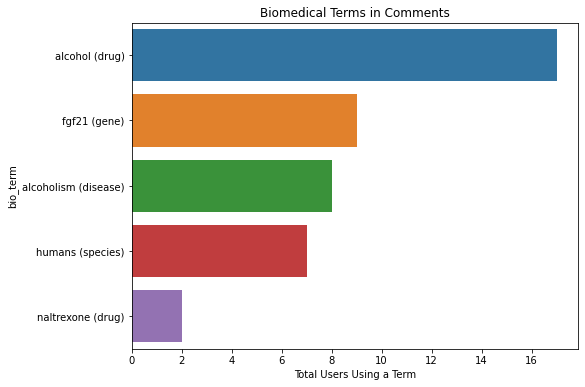

,bio_term,obj,authorChannelId
0,alcohol (drug),drug,17
1,fgf21 (gene),gene,9
2,alcoholism (disease),disease,8
3,humans (species),species,7
4,naltrexone (drug),drug,2


In [ ]:
# dfwords = group_bio_words_author_count(df, 'bio_term',mention_min=2)
# plot_bio_terms(x=dfwords.authorChannelId ,y=dfwords.bio_term, xlabel='Total Users Using a Term')
# dfwords

# Unique Comments that mention a term
> In this case we see that they are the nearly the same but it appears one user commented 2x using the term 'alcohol'
(for some reasone I have to comment this graph out for it to run with nbdev)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


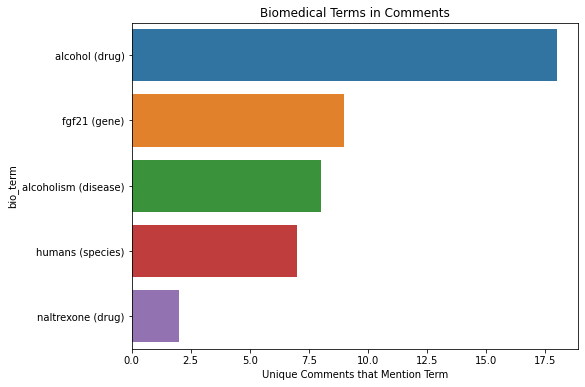

,bio_term,obj,comidx
0,alcohol (drug),drug,18
1,fgf21 (gene),gene,9
2,alcoholism (disease),disease,8
3,humans (species),species,7
4,naltrexone (drug),drug,2


In [ ]:
# dfwords = group_bio_words_com_count(df, 'bio_term',mention_min=2)
# plot_bio_terms(x=dfwords.comidx ,y=dfwords.bio_term, xlabel='Unique Comments that Mention Term')
# dfwords

### Terms Mentioned Infrequently

In [ ]:
dfwords = group_bio_words_author_count(df, 'bio_term',mention_min=1)
dfwords[dfwords.authorChannelId< 2]

,bio_term,obj,authorChannelId
5,acamprosate (drug),drug,1
6,patients (species),species,1
7,medical professionals (cell_type),cell_type,1
8,metabolic syndrome (disease),disease,1
9,munchies (species),species,1
10,nicotinamide riboside (drug),drug,1
11,non-alcoholism (disease),disease,1
12,participants (species),species,1
13,pregabalin (drug),drug,1
14,ketosis (disease),disease,1
